In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import os
from tqdm import tqdm
from io import StringIO
import string
from google.cloud import firestore

In [23]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "auth/oca-sourcing-firebase-adminsdk-kqr5l-5a5077ada0.json"

### **Exploring the Data: Examine a single PPP file**

In [24]:
ppp_co = "data/ppp_by_state/ppp_loans_state_AL.csv"
ppp_co_df = pd.read_csv(ppp_co)
ppp_co_df

,loan_amount,business_name,address,city,state,zip,naics_code,business_type,race_ethnicity,gender,...,date_approved,lender,cd,source_file,na_flag,dupe_flag,year_approved,address_clean,state_clean,city_clean
0,133900.0,"CHARLES MONEY LOGGING, INC",651 W WASHINGTON ST,ABBEVILLE,AL,36310,113110.0,Corporation,Unanswered,Unanswered,...,2020-04-05,HNB First Bank,AL-02,01 PPP sub 150k through 112420.csv,False,False,2020,651 W WASHINGTON ST,AL,ABBEVILLE
1,126200.0,"MONEY FORD , INC.",408 Dothan Rd,ABBEVILLE,AL,36310,441110.0,Corporation,White,Unanswered,...,2020-04-07,Ameris Bank,AL-02,01 PPP sub 150k through 112420.csv,False,False,2020,408 DOTHAN RD,AL,ABBEVILLE
2,121384.0,"MURPHY'S STATION PAINT & BODY WORK, INC",1107 STATE HWY 27,ABBEVILLE,AL,36310,811121.0,Corporation,Unanswered,Unanswered,...,2020-04-08,PeoplesSouth Bank,AL-02,01 PPP sub 150k through 112420.csv,False,False,2020,1107 STATE HWY 27,AL,ABBEVILLE
3,115200.0,"BILLY LAWRENCE BUICK-GMC, INC",525 KIRKLAND ST,ABBEVILLE,AL,36310,441110.0,Corporation,Unanswered,Unanswered,...,2020-04-09,HNB First Bank,AL-02,01 PPP sub 150k through 112420.csv,False,False,2020,525 KIRKLAND ST,AL,ABBEVILLE
4,95980.0,"ABBEVILLE MILLING, INC.",112 OZARK RD,ABBEVILLE,AL,36310,113310.0,Corporation,Unanswered,Unanswered,...,2020-04-10,PeoplesSouth Bank,AL-02,01 PPP sub 150k through 112420.csv,False,False,2020,112 OZARK RD,AL,ABBEVILLE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69328,1417.0,FREDDIE TUCKER SR,1227 e 4th ave,York,AL,36925,484122.0,Independent Contractors,Unanswered,Unanswered,...,2020-06-16,"Kabbage, Inc.",AL-07,01 PPP sub 150k through 112420.csv,False,False,2020,1227 E 4 TH AVE,AL,YORK
69329,1300.0,CRAIG S ELLINGTON,425 Hinds Rd,York,AL,36925,484121.0,Limited Liability Company(LLC),Unanswered,Unanswered,...,2020-04-30,Regions Bank,AL-07,01 PPP sub 150k through 112420.csv,False,False,2020,425 HINDS RD,AL,YORK
69330,1300.0,STEVEN WRENN,205 MADISON ST,YORK,AL,36925,484121.0,Independent Contractors,Unanswered,Unanswered,...,2020-04-30,Guaranty Bank,AL-07,01 PPP sub 150k through 112420.csv,False,False,2020,205 MADISON ST,AL,YORK
69331,1198.0,JAMES T LOVE 111,502 Lincoln st,york,AL,36925,484122.0,Self-Employed Individuals,Unanswered,Unanswered,...,2020-07-17,"Kabbage, Inc.",AL-07,01 PPP sub 150k through 112420.csv,False,False,2020,502 LINCOLN ST,AL,YORK


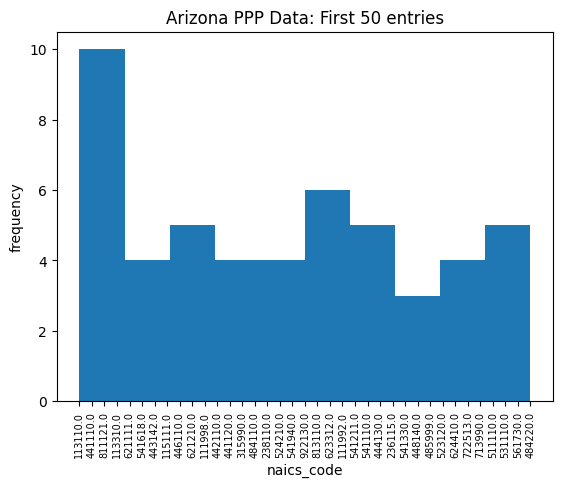

In [25]:
plt.hist(ppp_co_df["naics_code"][:50].astype(str))
plt.xlabel("naics_code")
plt.ylabel("frequency")
plt.title("Arizona PPP Data: First 50 entries")
plt.xticks(rotation=90, fontsize = 7)
plt.show()

### **Data Acquisition: web scraping the PPP page**
Functions used to acquire PPP data using webscraping

In [26]:
ppp_url = 'https://archive.investigativereportingworkshop.org/news/download-state-by-state-ppp-loan-data/'
download_dir = "data/ppp_by_state"
#urls = scrape_urls(url)
#download_files(urls, download_dir)

In [27]:
# Data functions
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

# Function to perform the web scraping
def scrape_urls(page_url):
    # add a header to prevent error 403
    response = requests.get(page_url, headers=headers)
    response.raise_for_status()  # Check for request errors
    
    # Parse the webpage with BeautifulSoup
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Find all the <a> tags, you might need to adjust this if it doesn't find the right links
    links = soup.find_all('a')
    
    # Filter and return URLs pointing to the CSV files
    csv_urls = [link['href'] for link in links if link['href'].endswith('.csv')]
    return csv_urls

def download_url_to_csv(url, download_dir):
    '''Expects URL to linnk to a valid csv and that download dir exists'''
    filename = url.split('/')[-1]  # Extract filename from URL
    save_path = os.path.join(download_dir, filename)
        
    # Download the file
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Check for request errors
    
    # Save the file
    with open(save_path, 'wb') as file:
        file.write(response.content)

    print(f'Downloaded: {filename}')
    
def download_url_to_df(url):
    '''Expects URL to linnk to a valid csv '''
    response = requests.get(url, headers=headers)
    response.raise_for_status()  # Check for request errors
    data = StringIO(response.content.decode('utf-8'))
    return pd.read_csv(data)

# Function to download files from a list of URLs
def download_files(urls, download_dir):
    os.makedirs(download_dir, exist_ok=True)  # Ensure the download directory exists
    
    for url in urls:
        filename = url.split('/')[-1]  # Extract filename from URL
        save_path = os.path.join(download_dir, filename)
        
        # Download the file
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Check for request errors
        
        # Save the file
        with open(save_path, 'wb') as file:
            file.write(response.content)
        
        print(f'Downloaded: {filename}')

### Writing the data to firestore database
Write the data, where each collection is naics_code and the documents correspond to a business with that code. Attributes will be all other columns and state will be an attribute

_Considerations_: NaN naics_code?

In [45]:
num_docs = 0

def remove_punctuation(input_string):
    # Create a translation table that maps each punctuation character to None
    translator = str.maketrans('', '', string.punctuation)
    # Translate the input string using the translation table
    return input_string.translate(translator)

def add_business_name_words(row_dict):
    business_name = str(row_dict["business_name"])
    words = business_name.split(" ")
    for i,word in enumerate(words):
        word = remove_punctuation(word)
        new_key = f"business_name_word_{i}"
        row_dict[new_key] = word
    

# Initialize an empty dictionary
def convert_ppp_df_into_naics_dict(df, v = False):
    naics_dict = {}

    # Iterate over each row in the DataFrame
    for index, row in tqdm(df.iterrows()):
        # Get the naics_code for the current row
        naics_code = row['naics_code']
        naics_code = str(naics_code).split(".")[0]
        if v:
            print("NAICS:",naics_code)

        # Create a dictionary for the row, excluding the naics_code column
        row_dict = row.drop('naics_code').to_dict()
        
        # add the individual words of business_name as additional entries
        add_business_name_words(row_dict)

        # If the naics_code is not already a key in the dictionary, add it
        if naics_code not in naics_dict:
            naics_dict[naics_code] = []

        # Append the row dictionary to the corresponding list in the dictionary
        naics_dict[naics_code].append(row_dict)
    return naics_dict

def convert_ppp_df_into_doc_list(df):
    documents = []
    # Iterate over each row in the DataFrame
    for index, row in tqdm(df.iterrows()):
        # Get the naics_code for the current row
        naics_code = row['naics_code']
        naics_code = str(naics_code).split(".")[0]
        row["naics_code"] = naics_code

        # Create a dictionary for the row, excluding the naics_code column
        row_dict = row.to_dict()
        
        # add the individual words of business_name as additional entries
        add_business_name_words(row_dict)

        # Append the row dictionary to the corresponding list in the dictionary
        documents.append(row_dict)
    return documents

def write_ppp_df_to_firestore_by_row(df, client, collection_name = "ppp", count_docs = True):
    collection_ref = client.collection(collection_name)
    docs = convert_ppp_df_into_doc_list(df)
    for doc in docs:
        collection_ref.add(doc)
    print("State: ", df["state"][0])
    print("Added", len(docs), "documents to database")
    
def write_ppp_df_to_firestore_by_row_with_batch(df, client, collection_name = "ppp", count_docs = True, batch_size=500):
    collection_ref = client.collection(collection_name)
    batch = db.batch()
    docs = convert_ppp_df_into_doc_list(df)
    
    print("State: ", df["state"][0])
    print("Adding", len(docs), "documents to database")
    
    batch_num = 0
    count = 0
    for doc in tqdm(docs):
        doc_ref = collection_ref.document()  # Create a new document reference
        batch.set(doc_ref, doc)
        count += 1
        
        # Commit the batch every 500 operations, as that's the limit
        if count % 500 == 0:
            batch_num+=1
            print("Committing batch", batch_num)
            batch.commit()
            batch = db.batch()  # Start a new batch after committing
    
    # Commit any remaining documents if there are fewer than 500 left
    if count % 500 != 0:
        batch.commit()

    print(f"Batch write completed. Total documents written: {count}")
        
    print("State: ", df["state"][0])
    print("Added", len(docs), "documents to database")
    
def write_ppp_df_to_firestore_by_naics(df, client):
    naics_dict = convert_ppp_df_into_naics_dict(df)
    for naics_code in naics_dict:
        collection_ref = client.collection(str(naics_code))
        for data in naics_dict[naics_code]:
            print(data)
            collection_ref.add(data)

def clean_business_name(df):
    # clean business names
    df["business_name"] = df["business_name"].str.strip().str.lower().str.rstrip('.')
    df['business_name'] = df['business_name'].str.replace(r'[\r\n]', '', regex=True)
    df['business_name'] = df['business_name'].str.replace(r'\s*,\s*', ', ', regex=True)
    df['business_name'] = df['business_name'].str.replace(r'\s*inc', ' inc', regex=True, case=False)
    df['business_name'] = df['business_name'].str.replace(r'\s*llc', ' llc', regex=True, case=False)
    

In [46]:
def delete_collection(coll_ref, batch_size):
    docs = coll_ref.limit(batch_size).stream()
    deleted = 0

    for doc in docs:
        doc.reference.delete()
        deleted += 1

    if deleted >= batch_size:
        delete_collection(coll_ref, batch_size)

def list_and_delete_collections(db, delete=False):
    # List all collections
    collections = db.collections()
    for collection in collections:
        print(f'Collection ID: {collection.id}')

        # Optionally, delete all documents in the collection
        if delete:
            delete_collection(collection, batch_size=10)
            print(f'Deleted all documents from {collection.id}')

In [31]:
db = firestore.Client()

In [19]:
#list_and_delete_collections(db, delete=True)

Collection ID: ppp
Deleted all documents from ppp


In [33]:
urls = scrape_urls(ppp_url)
urls

['https://publicaccountability.s3.amazonaws.com/PPP/ppp_loans_state_AL.csv',
 'https://publicaccountability.s3.amazonaws.com/PPP/ppp_loans_state_AK.csv',
 'https://publicaccountability.s3.amazonaws.com/PPP/ppp_loans_state_AZ.csv',
 'https://publicaccountability.s3.amazonaws.com/PPP/ppp_loans_state_AR.csv',
 'https://publicaccountability.s3.amazonaws.com/PPP/ppp_loans_state_CA.csv',
 'https://publicaccountability.s3.amazonaws.com/PPP/ppp_loans_state_CO.csv',
 'https://publicaccountability.s3.amazonaws.com/PPP/ppp_loans_state_CT.csv',
 'https://publicaccountability.s3.amazonaws.com/PPP/ppp_loans_state_DE.csv',
 'https://publicaccountability.s3.amazonaws.com/PPP/ppp_loans_state_DC.csv',
 'https://publicaccountability.s3.amazonaws.com/PPP/ppp_loans_state_FL.csv',
 'https://publicaccountability.s3.amazonaws.com/PPP/ppp_loans_state_GA.csv',
 'https://publicaccountability.s3.amazonaws.com/PPP/ppp_loans_state_HI.csv',
 'https://publicaccountability.s3.amazonaws.com/PPP/ppp_loans_state_ID.csv',

In [35]:
IL_url = [url for url in urls if "_IL.csv" in url]
IL_url

['https://publicaccountability.s3.amazonaws.com/PPP/ppp_loans_state_IL.csv']

In [47]:
## main function
# write to database by naics code
for url in IL_url:
    df = download_url_to_df(url)
    clean_business_name(df)
    write_ppp_df_to_firestore_by_row_with_batch(df, db)

220917it [00:26, 8446.72it/s]


State:  IL
Adding 220917 documents to database
Committing batch 1


RetryError: Timeout of 60.0s exceeded, last exception: 429 Quota exceeded.

In [ ]:
# ## main function
# # write to database by naics code
# for url in urls:
#     df = download_url_to_df(url)
#     clean_business_name(df)
#     write_ppp_df_to_firestore(df, db)